# 🔌 Load the data and several core functions

In [1]:
import yfinance as yf

#SP500 ticker for comparison
sp500 = yf.download('^GSPC', period='max', interval='1d')
if sp500.empty:
    print("Aucune donnée récupérée pour le SP500.")
else:
    # Sélectionner uniquement les colonnes 'Date' et 'Close' et réinitialiser l'index
    sp500 = sp500[['Close']].reset_index()
    # Renommer la colonne 'Date' si nécessaire et supprimer la ligne de titre incorrecte
    sp500.columns = ['Date', 'Close']  # Si le nom de la colonne Date ne correspond pas à votre besoin
    # Sauvegarder dans un fichier CSV sans l'index
    sp500.to_csv('sp500.csv', index=False)
    print(f'Données sauvegardées dans sp500.csv')
sp500


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Aucune donnée récupérée pour le SP500.


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from pandas.tseries.holiday import USFederalHolidayCalendar, AbstractHolidayCalendar, Holiday
from pandas.tseries.offsets import CustomBusinessDay
from numba import jit
import time
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgb
from tqdm.auto import tqdm
from scipy import stats

# CONFIGURATION CENTRALISÉE
CONFIG_DATES = {
    # Paramètres de données
    'data_dir': "datasets_technicals/1d",
    'start_date': "2012-01-02", 
    'end_date': "2025-02-01"
}

class FrenchHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1),
        Holiday('Labor Day', month=5, day=1),
        Holiday('Victory in Europe Day', month=5, day=8),
        Holiday('Bastille Day', month=7, day=14),
        Holiday('Assumption Day', month=8, day=15),
        Holiday('All Saints Day', month=11, day=1),
        Holiday('Armistice Day', month=11, day=11),
        Holiday('Christmas', month=12, day=25)
    ]

def create_trading_calendar(start: str, end: str) -> pd.DatetimeIndex:
    """Crée un calendrier de trading en excluant les jours fériés américains et français."""
    us_cal = USFederalHolidayCalendar()
    fr_cal = FrenchHolidayCalendar()
    holidays = us_cal.holidays(start, end).union(fr_cal.holidays(start, end))
    return pd.date_range(start, end, freq=CustomBusinessDay(holidays=holidays))

def load_data(config: dict, fill_limit: int = 5) -> tuple[dict, pd.DatetimeIndex]:
    """Charge les données et calcule les dates disponibles en une seule passe."""
    data = {}
    all_dates = set()
    files = list(Path(config['data_dir']).glob('*.csv'))
    
    for f in tqdm(files, desc="Chargement des données"):
        df = pd.read_csv(f, parse_dates=['Date'])
        all_dates.update(df['Date'])
        df = df.set_index('Date').sort_index()
        data[f.stem] = df
    
    start_date, end_date = min(all_dates), max(all_dates)
    trading_days = create_trading_calendar(start_date, end_date)
    
    for ticker, df in data.items():
        df = df.reindex(trading_days)
        for col in ['Close', 'Volume', 'Momentum252']:
            if col in df.columns:
                df[col] = df[col].ffill(limit=fill_limit)
        data[ticker] = df
    
    return data, trading_days


def get_color_scheme(date):
    """Générer un schéma de couleur basé sur l'année et le trimestre."""
    year = date.year
    quarter = (date.month - 1) // 3
    
    # Palette de couleurs par année
    base_colors = {
        # (Votre dictionnaire base_colors original ici)
        1980: '#2F4F4F',   # Gris-vert
        1981: '#A52A2A',   # Marron
        1982: '#FF6347',   # Tomate
        1983: '#40E0D0',   # Turquoise
        1984: '#8A2BE2',   # Bleu violet
        1985: '#5F9EA0',   # Gris-bleu
        1986: '#D2691E',   # Chocolat
        1987: '#CD5C5C',   # Rosé
        1988: '#DAA520',   # Or
        1989: '#B8860B',   # Jaune foncé
        1990: '#20B2AA',   # Vert-de-mer
        1991: '#00008B',   # Bleu marine
        1992: '#008B8B',   # Bleu-vert foncé
        1993: '#A9A9A9',   # Gris foncé
        1994: '#006400',   # Vert foncé
        1995: '#FF4500',   # Orange rougeâtre
        1996: '#2E8B57',   # Vert
        1997: '#7FFF00',   # Vert clair
        1998: '#D2691E',   # Chocolat
        1999: '#9ACD32',   # Jaune-vert
        2000: '#8B0000',   # Rouge foncé
        2001: '#B0C4DE',   # Bleu clair
        2002: '#A9A9A9',   # Gris
        2003: '#8B008B',   # Magenta foncé
        2004: '#FF8C00',   # Orange foncé
        2005: '#D3D3D3',   # Gris clair
        2006: '#C71585',   # Violet foncé
        2007: '#FF1493',   # Rose vif
        2008: '#ADFF2F',   # Vert jaunâtre
        2009: '#F0E68C',   # Jaune pâle
        2010: '#B22222',   # Rouge brique
        2011: '#FFD700',   # Or
        2012: '#1f77b4',   # Bleu
        2013: '#2ca02c',   # Vert
        2014: '#ff7f0e',   # Orange
        2015: '#d62728',   # Rouge
        2016: '#9467bd',   # Violet
        2017: '#8c564b',   # Marron
        2018: '#e377c2',   # Rose
        2019: '#7f7f7f',   # Gris
        2020: '#bcbd22',   # Jaune-vert
        2021: '#17becf',   # Cyan
        2022: '#1a55FF',   # Bleu royal
        2023: '#FF1a1a',   # Rouge vif
        2024: '#B0E0E6',   # Bleu pâle
        2025: '#4682B4',   # Bleu acier
        2026: '#D2691E',   # Chocolat
        2027: '#FF6347',   # Tomate
        2028: '#A52A2A',   # Marron
        2029: '#8B4513',   # Sienne brune
        2030: '#2F4F4F'    # Gris-vert
    }
    
    # Ajustement de la luminosité selon le trimestre
    brightness_factor = 0.6 + (quarter * 0.1)  # 0.6, 0.7, 0.8, 0.9
    
    base_color = np.array(to_rgb(base_colors.get(year, '#1f77b4')))
    adjusted_color = base_color * brightness_factor
    adjusted_color = np.clip(adjusted_color, 0, 1)
    
    return adjusted_color

def evaluate_metrics(metrics):
    thresholds = {
        'Annual Return': {
            'good': 15, 'medium': 8, 'neutral': 3,
            'explain': {
                'good': 'Plus de 15% de rendement annuel',
                'medium': 'Entre 8% et 15% de rendement annuel',
                'neutral': 'Entre 3% et 8% de rendement annuel',
                'bad': 'Moins de 3% de rendement annuel'
            },
            'format': '.2f%'
        },
        'Sharpe': {
            'good': 1.0, 'medium': 0.5, 'neutral': 0.2,
            'explain': {
                'good': 'Plus de 1.0 : Excellent ratio rendement/risque',
                'medium': 'Entre 0.5 et 1.0 : Bon compromis',
                'neutral': 'Entre 0.2 et 0.5 : Risque élevé',
                'bad': 'Moins de 0.2 : Risque excessif'
            },
            'format': '.3f'
        },
        'Profit Factor': {
            'good': 2.0, 'medium': 1.5, 'neutral': 1.2,
            'explain': {
                'good': 'Plus de 200% de gains vs pertes',
                'medium': 'Entre 150% et 200% de gains vs pertes',
                'neutral': 'Entre 120% et 150% de gains vs pertes',
                'bad': 'Moins de 120% de gains vs pertes'
            },
            'format': '.3f'
        },
        'Sortino': {
            'good': 2.0, 'medium': 1.0, 'neutral': 0.5,
            'explain': {
                'good': 'Au-dessus de 2.0 : Excellent contrôle du risque',
                'medium': 'Entre 1.0 et 2.0 : Bon contrôle',
                'neutral': 'Entre 0.5 et 1.0 : Contrôle limité',
                'bad': 'Sous 0.5 : Risque mal maîtrisé'
            },
            'format': '.3f'
        },
        'Expectancy': {
            'good': 0.01, 'medium': 0.001, 'neutral': 0.0001,
            'explain': {
                'good': 'Plus de 1% de gain moyen par trade',
                'medium': 'Entre 0.1% et 1% par trade',
                'neutral': 'Entre 0.01% et 0.1% par trade',
                'bad': 'Moins de 0.01% par trade'
            },
            'format': '.5f'
        }
    }
    
    # ANSI color codes
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    RED = '\033[91m'
    GRAY = '\033[90m'
    BOLD = '\033[1m'
    END = '\033[0m'
    
    pros = []
    neutral = []
    cons = []
    
    def get_category_and_color(name, value):
        if value >= thresholds[name]['good']:
            return 'good', GREEN
        elif value >= thresholds[name]['medium']:
            return 'medium', YELLOW
        elif value >= thresholds[name]['neutral']:
            return 'neutral', BLUE
        return 'bad', RED
    
    # Évaluation des métriques
    for name, value in metrics.items():
        if name in thresholds:
            category, color = get_category_and_color(name, value)
            if thresholds[name]['format'].endswith('%'):
                formatted_value = f"{value:.2f}%"
            else:
                formatted_value = f"{value:.3f}"
            metric_info = f"{name}: {color}{formatted_value}{END}"
            explanation = f"{GRAY}{thresholds[name]['explain'][category]}{END}"
            
            if category in ['good', 'medium']:
                pros.append((metric_info, explanation))
            elif category == 'neutral':
                neutral.append((metric_info, explanation))
            else:
                cons.append((metric_info, explanation))
    
    # Affichage
    print(f"\n\n\n\n{BOLD}🎯 Performance Analysis{END}")
    print("=" * 70)
    
    print(f"\n{GREEN}✨ PROS{END}")
    print("-" * 70)
    if pros:
        for metric, explain in pros:
            print(f"🟢 {metric}")
            print(f"   {explain}")
    else:
        print("None found")
    
    print(f"\n{BLUE}⚖️ NEUTRAL{END}")
    print("-" * 70)
    if neutral:
        for metric, explain in neutral:
            print(f"🔷 {metric}")
            print(f"   {explain}")
    else:
        print("None found")
    
    print(f"\n{RED}⚠️ CONS{END}")
    print("-" * 70)
    if cons:
        for metric, explain in cons:
            print(f"🔴 {metric}")
            print(f"   {explain}")
    else:
        print("None found")
    
    print("\n" + "=" * 70)


data, trading_days = load_data(CONFIG_DATES)

Chargement des données:   0%|          | 0/1459 [00:00<?, ?it/s]

# 🦑 Backtest engine
###### 
###### Voici les améliorations potentielles majeures : ###### Allocation dynamique du capital basée sur la volatilité
###### Position sizing adaptatif selon ATR
###### Corrélation entre positions pour diversification optimale
###### Time-stop pour sortir des positions stagnantes
###### Combiner plusieurs timeframes de momentum (21j, 63j, 252j)
###### Ajouter filtres de tendance (ex: MM200)
###### Indicateurs de volatilité (ATR, Bollinger)
###### Score composite multi-facteurs
###### Filtre de tendance globale de marché
###### Indicateur de regime de volatilité
###### Exposition variable selon conditions macro
###### Entrées échelonnées
###### Sorties partielles sur objectifs
###### Heures d'entrée/sortie optimales
###### Gestion des gaps


CONFIG_TRADES = {
    
    'start_date': CONFIG_DATES['start_date'],  # Réutilisation du paramètre
    'end_date': CONFIG_DATES['end_date'],      # Réutilisation du paramètre
    
    # Paramètres de simulation
    'simulation_years': 1,  # 6 mois
    'n_simulations': 100,
    'trailing_stop_pct' : 0.29,
    
    # Paramètres de momentum
    # Ce paramètre permet de lisser les prises de position trop réactives et d'éviter un achat/revente
    # impulsif en cas de hausse brutale suivie d'une correction.
    'momentum_period': 7,  #Momentum court-terme (20 par défaut)
    'momentum_multiplier': 49.92,  # Multiplicateur pour le ranking court terme (4 par défaut) : si on utilise un top-3 sur le LT, on utilise un 3x4= top-12 sur le ST.
    
    # Paramètres de sélection de Sharpe et Volatilité
    'volatility_window': 20,  # Rolling window for volatility calculation
    'volatility_annualization_factor': 252,  # Trading days in a year
    'vol_threshold_multiplier': 5.5,  # Multiplier for volatility threshold
    'sharpe_filter_threshold': -8.5,  # Sharpe ratio threshold for risk filtering
    
    # Paramètres de portefeuille
    'initial_cash': 10000,
    'position_size': 908,
    'fee_rate': 0.0025,
    
    # Paramètres de sélection
    'top_n': 11,  # Nombre de stocks à sélectionner
    'volume_percentile': 75.0,  # Filtrage par volume
    
    # Autres paramètres
    'random_seed': None  # None pour un seed aléatoire
}

🔄 Average daily operations: 2.49


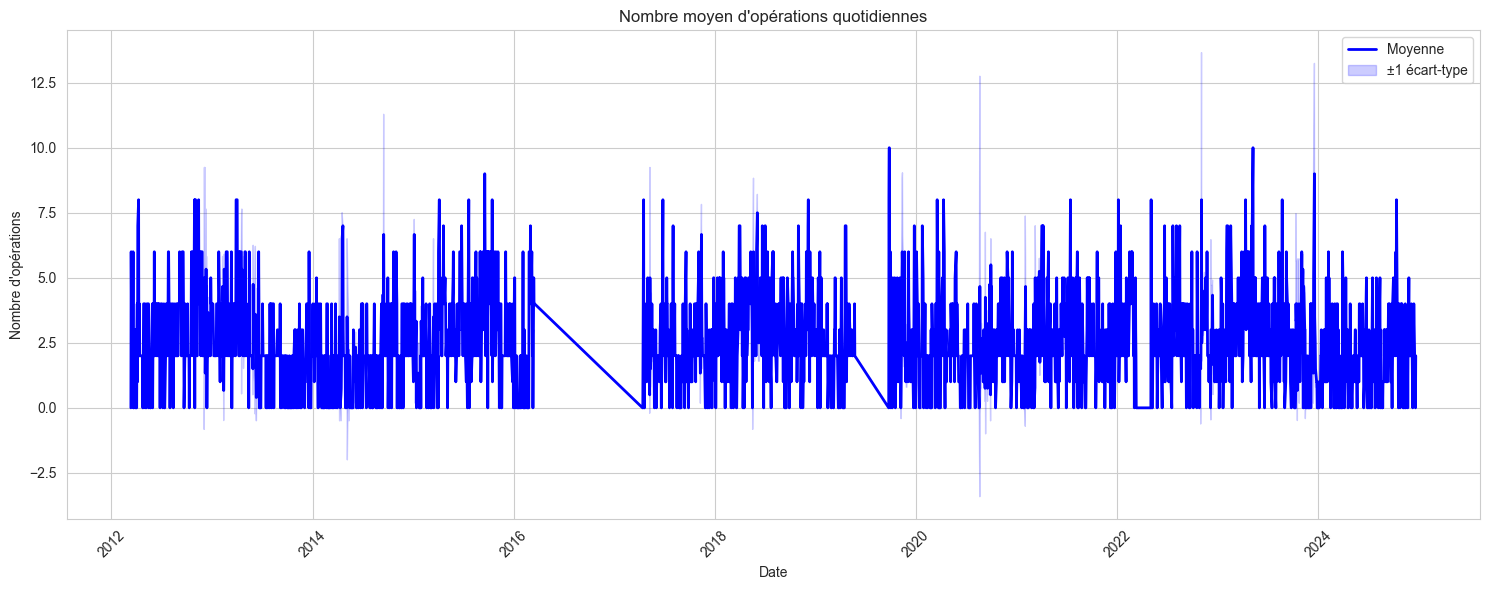

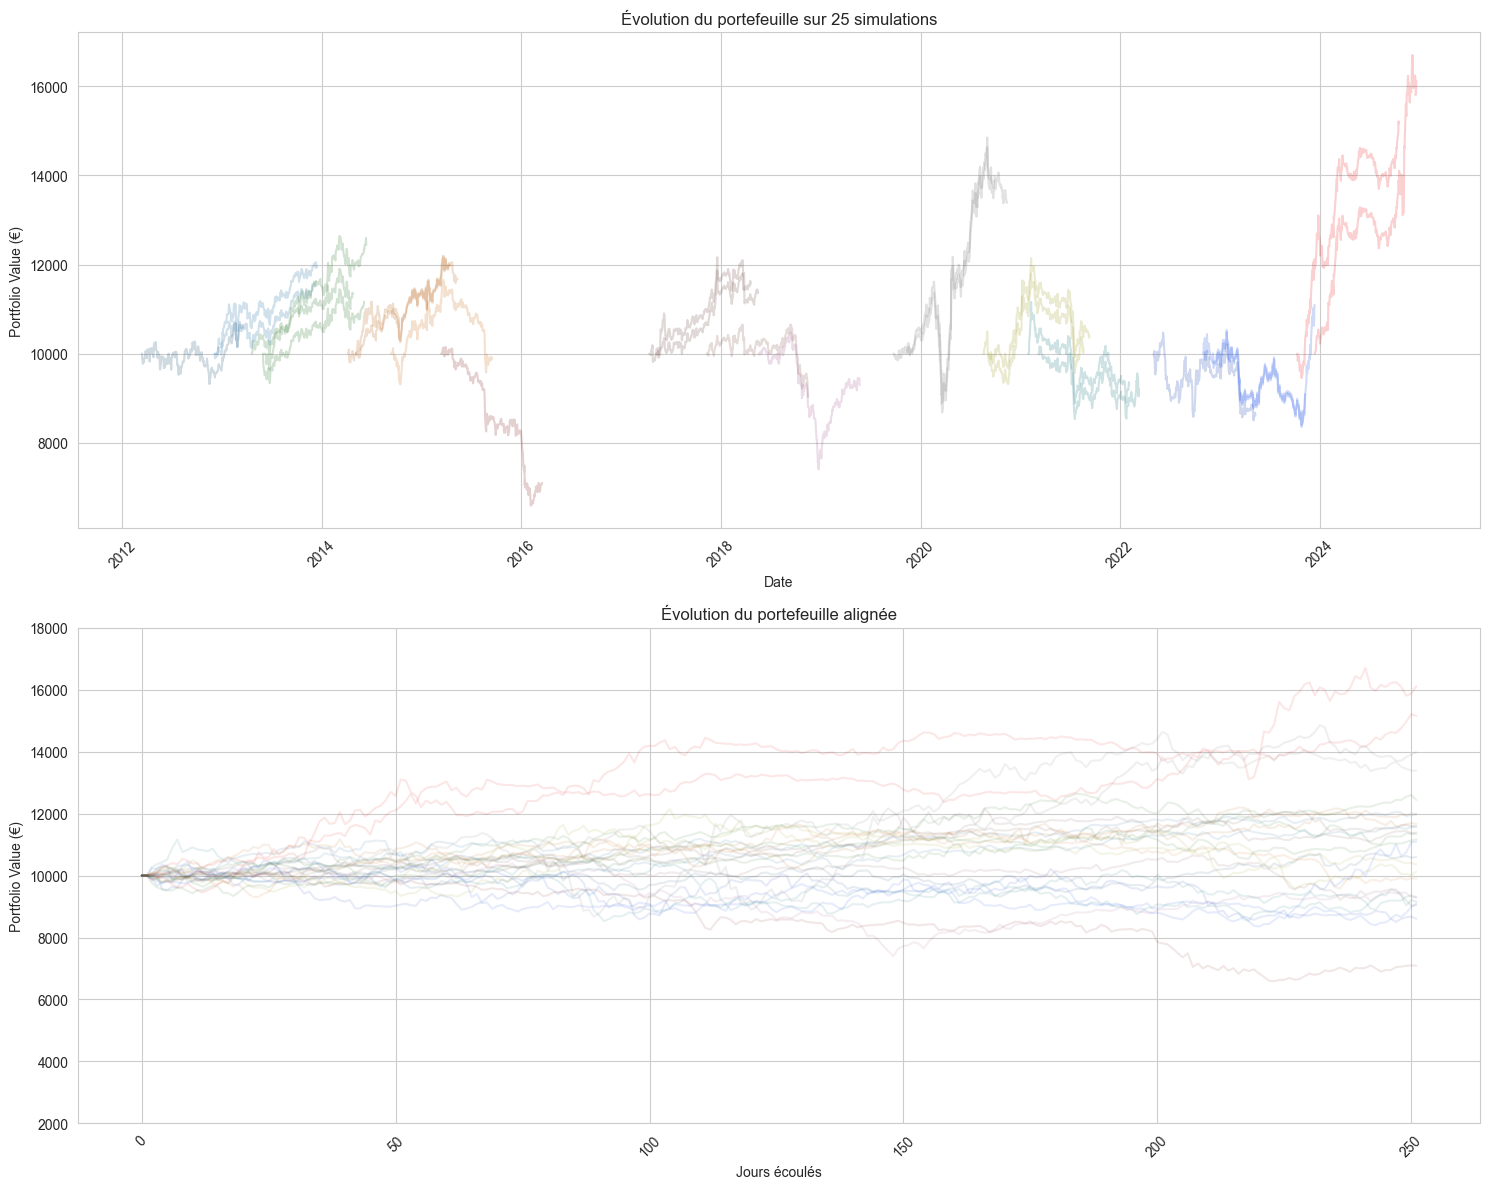

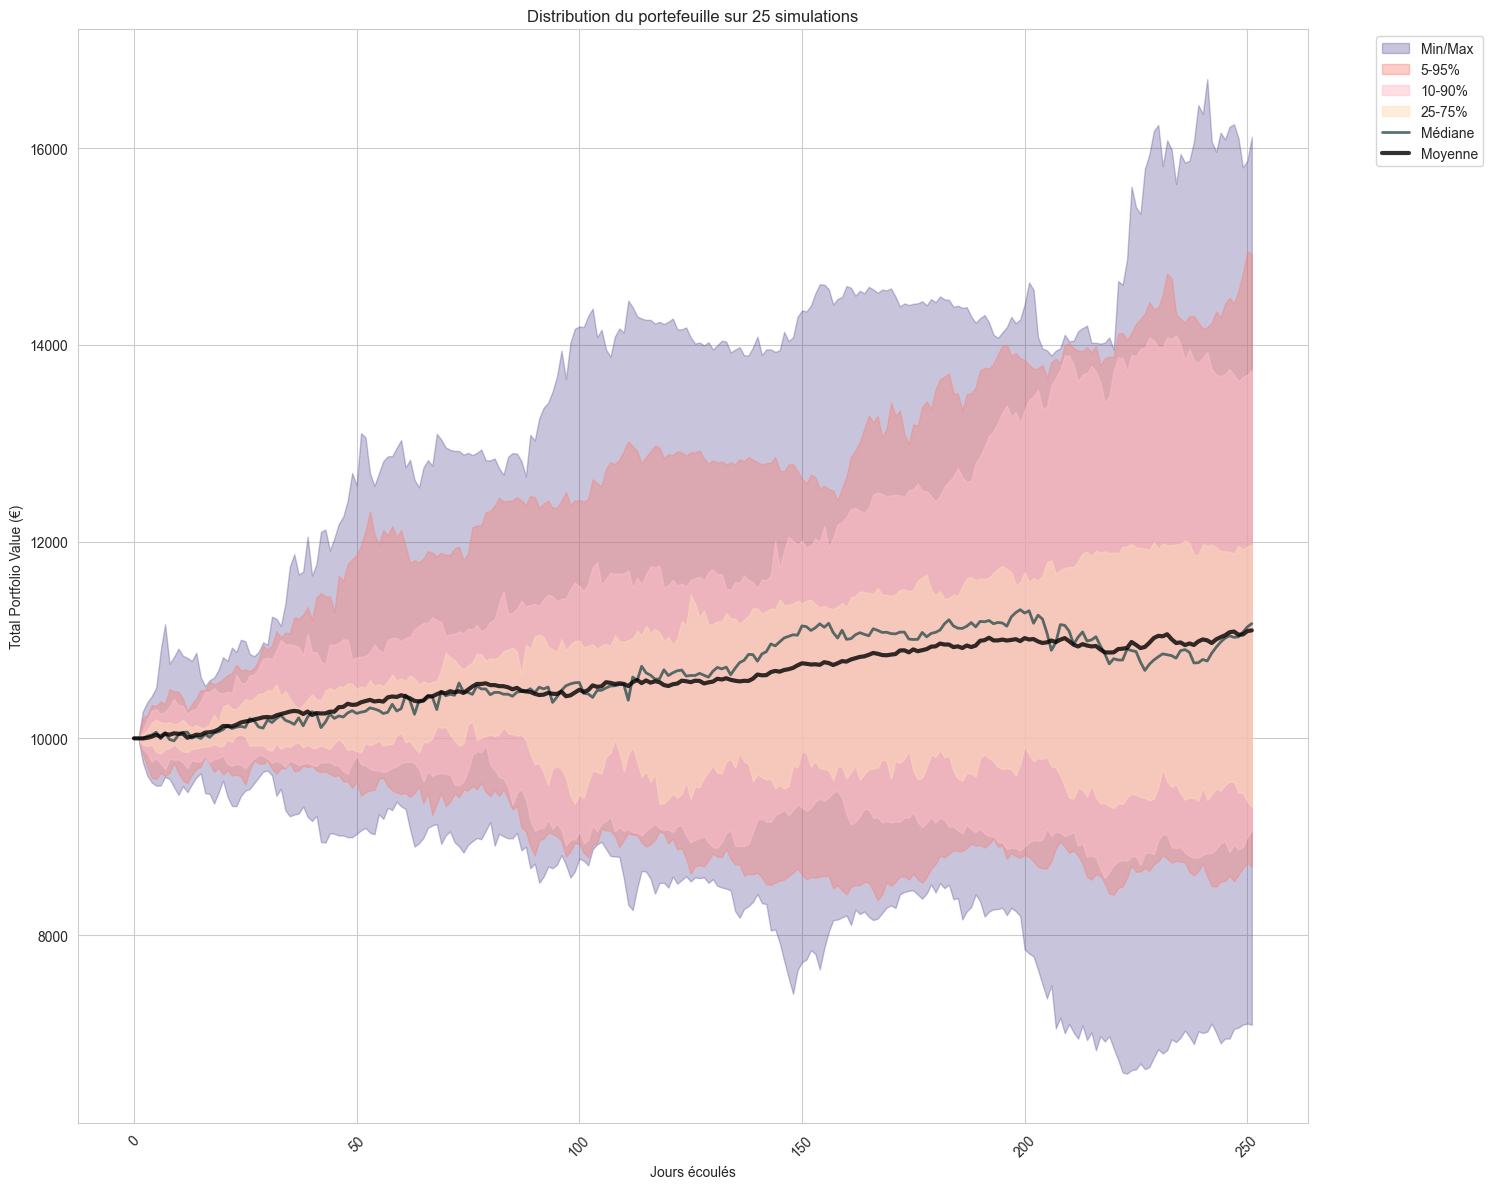

🤑 Total Return: 10.98%
📉 Avg annual Return: 10.50%
📉 Avg daily Return: 0.04%
📈 Avg Volatility: 0.19%
🎈 Sharpe ratio: 0.223
🎯 Sortino: 0.398
💰 Profit Factor: 1.731
💫 Expectancy: 0.000

⏰ Temps total d'exécution: 26.18 secondes




🎯 Performance Analysis

✨ PROS
----------------------------------------------------------------------
🟢 Annual Return: 10.98%
   Entre 8% et 15% de rendement annuel
🟢 Profit Factor: 1.731
   Entre 150% et 200% de gains vs pertes

⚖️ NEUTRAL
----------------------------------------------------------------------
🔷 Sharpe: 0.223
   Entre 0.2 et 0.5 : Risque élevé
🔷 Expectancy: 0.000
   Entre 0.01% et 0.1% par trade

⚠️ CONS
----------------------------------------------------------------------
🔴 Sortino: 0.398
   Sous 0.5 : Risque mal maîtrisé



,simulation,date,date_rank,tickers_held,tickers_bought,tickers_sold,ticker_values,cash,holdings_value,portfolio_value,num_buys,num_sells,num_operations,cum_operations
2023-11-16,Sim 9,2023-11-16,233,"BITO, MSTR, RR.L, NVDA, GBTC, META",,,"{'BITO': 1914.106878210177, 'MSTR': 1856.06288...",-20.997462,9580.102234,9559.104772,0.0,0.0,0.0,718.0
2023-11-17,Sim 9,2023-11-17,234,"BITO, MSTR, RR.L, NVDA, GBTC, META",,,"{'BITO': 1942.6438704860063, 'MSTR': 1845.2091...",-20.997462,9590.904048,9569.906586,0.0,0.0,0.0,718.0
2023-11-20,Sim 9,2023-11-20,235,"BITO, MSTR, RR.L, NVDA, GBTC, META",,,"{'BITO': 2002.8895436988391, 'MSTR': 1929.8757...",-20.997462,9851.755390,9830.757928,0.0,0.0,0.0,718.0
2023-11-21,Sim 9,2023-11-21,236,"BITO, MSTR, RR.L, NVDA, GBTC, META",,,"{'BITO': 1962.7255010593396, 'MSTR': 1871.0911...",-20.997462,9677.764885,9656.767424,0.0,0.0,0.0,718.0
2023-11-22,Sim 9,2023-11-22,237,"MSTR, COIN, RR.L, NVDA, GBTC, META",COIN,BITO,"{'MSTR': 1927.4089449231913, 'COIN': 1875.0, '...",106.101580,9664.217911,9770.319491,1.0,1.0,2.0,720.0
2023-11-24,Sim 9,2023-11-24,238,"MSTR, COIN, RR.L, NVDA, GBTC, META",,,"{'MSTR': 1974.3152546424424, 'COIN': 1982.9519...",106.101580,9834.076224,9940.177804,0.0,0.0,0.0,720.0
2023-11-27,Sim 9,2023-11-27,239,"MSTR, COIN, RR.L, NVDA, GBTC, META",,,"{'MSTR': 1879.9713363036915, 'COIN': 2055.5491...",106.101580,9761.237544,9867.339124,0.0,0.0,0.0,720.0
2023-11-28,Sim 9,2023-11-28,240,"MSTR, COIN, RR.L, NVDA, GBTC, META",,,"{'MSTR': 1919.7811141182553, 'COIN': 2201.4302...",106.101580,10093.548155,10199.649735,0.0,0.0,0.0,720.0
2023-11-29,Sim 9,2023-11-29,241,"MSTR, COIN, RR.L, NVDA, GBTC, META",,,"{'MSTR': 1924.448871731532, 'COIN': 2193.70708...",106.101580,10075.118406,10181.219986,0.0,0.0,0.0,720.0
2023-11-30,Sim 9,2023-11-30,242,"BITO, MSTR, COIN, RR.L, NVDA, META",BITO,GBTC,"{'BITO': 1874.9999999999998, 'MSTR': 1891.0528...",131.894681,9861.759879,9993.654561,1.0,1.0,2.0,722.0


In [3]:
CONFIG_TRADES = {
    
    'start_date': CONFIG_DATES['start_date'],  # Réutilisation du paramètre
    'end_date': CONFIG_DATES['end_date'],      # Réutilisation du paramètre
    
    # Paramètres de simulation
    'simulation_years': 1,  # 6 mois
    'n_simulations': 25,
    'trailing_stop_pct' : 0.305,
    
    # Paramètres de momentum
    # Ce paramètre permet de lisser les prises de position trop réactives et d'éviter un achat/revente
    # impulsif en cas de hausse brutale suivie d'une correction.
    'momentum_period': 8,  #Momentum court-terme (20 par défaut)
    'momentum_multiplier': 34.53,  # Multiplicateur pour le ranking court terme (4 par défaut) : si on utilise un top-3 sur le LT, on utilise un 3x4= top-12 sur le ST.
    
    # Paramètres de sélection de Sharpe et Volatilité
    'volatility_window': 20,  # Rolling window for volatility calculation
    'volatility_annualization_factor': 252,  # Trading days in a year
    'vol_threshold_multiplier': 4.46,  # Multiplier for volatility threshold
    'sharpe_filter_threshold': -7.56,  # Sharpe ratio threshold for risk filtering
    
    # Paramètres de portefeuille
    'initial_cash': 10000,
    'position_size': 1250,
    'fee_rate': 0.0025,
    'use_adaptive_sizing': True,  # Activer/désactiver le sizing adaptatif
    
    # Paramètres de sélection
    'top_n': 8,  # Nombre de stocks à sélectionner
    'volume_percentile': 75.0,  # Filtrage par volume
    
    # Autres paramètres
    'random_seed': 5  # None pour un seed aléatoire
}






@jit(nopython=True, parallel=True)
def calculate_position_changes(prev_holdings, top_10_mask, close_prices, entry_prices, 
                              high_prices_since_entry, cash, position_size, fee_rate, 
                              trailing_stop_pct, volatility_values, volatility_mean, use_adaptive_sizing):
    """Calcule les changements de positions avec trailing stop-loss et sizing adaptatif."""
    new_holdings = prev_holdings.copy()
    new_entry_prices = entry_prices.copy()
    new_high_prices = high_prices_since_entry.copy()
    total_fees = 0.0

    # Mise à jour des plus hauts historiques
    active_positions = prev_holdings > 0
    new_high_prices[active_positions] = np.maximum(
        high_prices_since_entry[active_positions],
        close_prices[active_positions]
    )

    # Calcul du trailing stop
    trailing_stop_triggered = np.where(new_high_prices > 0, 
                                     close_prices / new_high_prices < (1 - trailing_stop_pct), 
                                     False)
    
    # Masque combiné pour toutes les conditions de vente
    sell_mask = active_positions & (trailing_stop_triggered | ~top_10_mask)
    
    # Calcul vectorisé des ventes
    sale_values = prev_holdings * close_prices * sell_mask
    total_sale_value = np.sum(sale_values)
    cash += total_sale_value * (1 - fee_rate)
    total_fees += total_sale_value * fee_rate
    
    # Mise à zéro des positions vendues
    new_holdings[sell_mask] = 0.0
    new_entry_prices[sell_mask] = 0.0
    new_high_prices[sell_mask] = 0.0

    # Acheter les nouvelles positions (une seule boucle d'achat)
    buy_candidates = np.where(top_10_mask & (new_holdings == 0))[0]
    for i in buy_candidates:
        if cash >= position_size:
            if use_adaptive_sizing:
                # Sizing adaptatif basé sur volatilité
                vol_ratio = volatility_values[i] / volatility_mean
                # Éviter division par zéro
                if vol_ratio <= 0.01:
                    vol_ratio = 0.01
                
                position_size_adjusted = position_size / vol_ratio
                # Limiter la taille maximale à 1.5x la position standard
                actual_position_size = min(position_size_adjusted, position_size * 1.5)
            else:
                # Sizing standard
                actual_position_size = position_size
            
            shares = actual_position_size / close_prices[i]
            cash -= actual_position_size
            total_fees += actual_position_size * fee_rate
            new_holdings[i] = shares
            new_entry_prices[i] = close_prices[i]
            new_high_prices[i] = close_prices[i]

    return new_holdings, new_entry_prices, new_high_prices, cash, total_fees


def optimized_backtest(data: dict, trading_days: pd.DatetimeIndex, config: dict):
    """Exécute le backtest avec tracking détaillé des opérations et masques de risque."""
    filtered_data = {ticker: df for ticker, df in data.items() if 'Momentum252' in df.columns}
    
    # DataFrames vectorisés
    close = pd.DataFrame({ticker: df['Close'] for ticker, df in filtered_data.items()}).reindex(trading_days)
    volume = pd.DataFrame({ticker: df['Volume'] for ticker, df in filtered_data.items()}).reindex(trading_days)
    momentum_lt = pd.DataFrame({ticker: df['Momentum252'] for ticker, df in filtered_data.items()}).reindex(trading_days)
    
    # Momentum court terme
    momentum_st = pd.DataFrame({
        ticker: df.get('Momentum20', close[ticker].pct_change(
            periods=config.get('momentum_period', 20), 
            fill_method=None
        )) for ticker, df in filtered_data.items()
    }).reindex(trading_days)

    # Calcul des masques de risque
    returns = close.pct_change(fill_method=None).fillna(0)
    # Calculate volatility with a safe handling of initial periods
    volatility_window = config.get('volatility_window', 20)
    volatility = returns.rolling(window=volatility_window, min_periods=1).std() * np.sqrt(config.get('volatility_annualization_factor', 252))
    vol_threshold = volatility.rolling(window=60, min_periods=1).mean()
    # Modify risk filter to be more permissive in early periods
    risk_filter = (volatility <= vol_threshold * config.get('vol_threshold_multiplier', 2.0)) | (volatility.isna())
    rolling_returns = returns.rolling(window=20, min_periods=1).mean() * 252
    rolling_std = returns.rolling(window=20, min_periods=1).std() * np.sqrt(252)
    sharpe = rolling_returns / rolling_std
    # More permissive Sharpe filter for initial periods
    sharpe_filter = (sharpe > config.get('sharpe_filter_threshold', -2)) | sharpe.isna()



    # Initialization des DataFrames de suivi
    holdings = pd.DataFrame(0.0, index=trading_days, columns=close.columns)
    entry_prices = pd.DataFrame(0.0, index=trading_days, columns=close.columns)
    high_prices = pd.DataFrame(0.0, index=trading_days, columns=close.columns)
    
    trading_metrics = pd.DataFrame(index=trading_days)
    trading_metrics['simulation'] = 'Sim 1'
    trading_metrics['date'] = trading_days
    trading_metrics['date_rank'] = range(1, len(trading_days) + 1)
    
    portfolio = pd.DataFrame({
        'cash': config['initial_cash'],
        'fees': 0.0,
        'portfolio_value': float(config['initial_cash'])
    }, index=trading_days, dtype=float)

    # Masques de volume et momentum combinés avec les filtres de risque
    valid_mask = ~momentum_lt.isna() & ~volume.isna() & ~close.isna()
    vol_thresholds = volume[valid_mask].apply(lambda x: np.nanpercentile(x, config['volume_percentile']), axis=1)
    all_filters = (volume.ge(vol_thresholds, axis=0) & 
                  valid_mask & 
                  risk_filter & 
                  sharpe_filter)

    # Rankings avec double momentum
    momentum_ranks_lt = momentum_lt.where(all_filters).rank(axis=1, ascending=False)
    momentum_ranks_st = momentum_st.where(all_filters).rank(axis=1, ascending=False)
    
    
    multiplier = config.get('momentum_multiplier', 4.0)
    top_selections = (momentum_ranks_lt <= config['top_n']) & (momentum_ranks_st <= config['top_n'] * multiplier)

    for i in range(1, len(trading_days)):
        date = trading_days[i]
        prev_date = trading_days[i - 1]

        prev_holdings_mask = holdings.loc[prev_date] > 0
        prev_tickers = close.columns[prev_holdings_mask].tolist()
        
        volatility_values = volatility.loc[date].fillna(volatility.loc[date].mean()).values
        volatility_mean = volatility_values.mean()

        new_holdings, new_entry_prices, new_high_prices, new_cash, fees = calculate_position_changes(
            holdings.loc[prev_date].values,
            top_selections.loc[date].values,
            close.loc[date].fillna(0).values,
            entry_prices.loc[prev_date].values,
            high_prices.loc[prev_date].values,
            portfolio.loc[prev_date, 'cash'],
            config['position_size'],
            config['fee_rate'],
            config['trailing_stop_pct'],
            volatility_values,
            volatility_mean,
            config.get('use_adaptive_sizing', False)  # Valeur par défaut False pour la compatibilité
        )

        holdings.loc[date] = new_holdings
        entry_prices.loc[date] = new_entry_prices
        high_prices.loc[date] = new_high_prices

        current_holdings_mask = new_holdings > 0
        current_tickers = close.columns[current_holdings_mask].tolist()

        ticker_values = pd.Series(new_holdings, index=close.columns) * close.loc[date]
        holdings_value = ticker_values[current_holdings_mask].sum()

        metrics_update = {
            'tickers_held': ', '.join(current_tickers),
            'tickers_bought': ', '.join(set(current_tickers) - set(prev_tickers)),
            'tickers_sold': ', '.join(set(prev_tickers) - set(current_tickers)),
            'ticker_values': str(ticker_values[current_holdings_mask].to_dict()),
            'cash': float(new_cash),
            'holdings_value': float(holdings_value),
            'portfolio_value': float(new_cash + holdings_value),
            'num_buys': int(len(set(current_tickers) - set(prev_tickers))),
            'num_sells': int(len(set(prev_tickers) - set(current_tickers))),
            'num_operations': int(len(set(current_tickers) - set(prev_tickers)) + len(set(prev_tickers) - set(current_tickers)))
        }

        for col, value in metrics_update.items():
            trading_metrics.loc[date, col] = value

        trading_metrics.loc[date, 'cum_operations'] = trading_metrics.loc[:date, 'num_operations'].sum()

        portfolio.loc[date] = [
            float(new_cash),
            portfolio.loc[prev_date, 'fees'] + fees,
            float(new_cash + holdings_value)
        ]

    return portfolio, holdings, entry_prices, trading_metrics

def run_multiple_simulations(config: dict):
    """Lance plusieurs simulations de backtest avec tracking détaillé."""
    trading_days = create_trading_calendar(config['start_date'], config['end_date'])
    
    # Sélection vectorisée des dates de départ
    DAYS_IN_YEAR = 252
    simulation_length = int(config['simulation_years'] * DAYS_IN_YEAR)
    np.random.seed(config['random_seed'])
    start_indices = np.random.choice(
        len(trading_days) - simulation_length,
        config['n_simulations'],
        replace=False
    )
    
    # Préallocation des résultats
    all_metrics = [None] * len(start_indices)
    all_portfolios = {}
    all_holdings = {}
    
    for i, start_idx in enumerate(start_indices, 1):
        sim_days = trading_days[start_idx:start_idx + simulation_length]
        
        # Exécution du backtest
        portfolio, holdings, entry_prices, metrics = optimized_backtest(data, sim_days, config)
        
        # Mise à jour de l'identifiant de simulation
        metrics['simulation'] = f'Sim {i}'
        
        # Stockage des résultats
        all_metrics[i-1] = metrics
        all_portfolios[f'Sim {i}'] = portfolio
        all_holdings[f'Sim {i}'] = holdings
        
    # Concaténation vectorisée des résultats
    combined_metrics = pd.concat(all_metrics, axis=0)
    combined_metrics = combined_metrics.sort_values(['simulation', 'date'])
    
    return {
        'metrics': combined_metrics,
        'portfolios': all_portfolios,
        'holdings': all_holdings
    }



# Lancer les simulations
start_time = time.time()

# Simulations avec la configuration centralisée
simulations = run_multiple_simulations(CONFIG_TRADES)
# Récupération des métriques
metrics_df = simulations['metrics']  # métriques détaillées de chaque simulation
portfolios_df = pd.DataFrame({sim: data['portfolio_value'] 
                            for sim, data in simulations['portfolios'].items()})

# Après le calcul des métriques existantes, ajoutez :
avg_daily_ops = metrics_df.groupby('simulation')['num_operations'].mean().mean()
print(f'🔄 Average daily operations: {avg_daily_ops:.2f}')





################################## PLOTTING ##################################

# Pour le plot, ajoutez :
plt.figure(figsize=(15, 6))
sns.set_style("whitegrid")

daily_ops = metrics_df.groupby(['simulation', 'date'])['num_operations'].sum().reset_index()
mean_ops = daily_ops.groupby('date')['num_operations'].mean()
std_ops = daily_ops.groupby('date')['num_operations'].std()

plt.plot(mean_ops.index, mean_ops.values, 
        label='Moyenne', color='blue', linewidth=2)
plt.fill_between(mean_ops.index, 
                mean_ops - std_ops, 
                mean_ops + std_ops, 
                alpha=0.2, color='blue', 
                label='±1 écart-type')

plt.title("Nombre moyen d'opérations quotidiennes")
plt.xlabel("Date")
plt.ylabel("Nombre d'opérations")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()




# Récupération et alignement des résultats
aligned_simulations = {
    label: pd.Series(portfolio['portfolio_value'].values, index=range(len(portfolio)))
    for label, portfolio in simulations['portfolios'].items()
}
df_aligned = pd.DataFrame(aligned_simulations)

# Premier graphique
plt.figure(figsize=(15, 12))
sns.set_style("whitegrid")
plt.subplot(2, 1, 1)
for label, portfolio in simulations['portfolios'].items():
    start_date = portfolio.index[0]
    color = get_color_scheme(start_date)
    year_quarter = f"{start_date.year}-Q{(start_date.month-1)//3 + 1}"
    plt.plot(portfolio.index, portfolio['portfolio_value'], 
             label=f"{label} ({year_quarter})", color=color, alpha=0.2)

plt.title(f"Évolution du portefeuille sur {CONFIG_TRADES['n_simulations']} simulations")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (€)")
plt.xticks(rotation=45)

# Deuxième graphique
plt.subplot(2, 1, 2)
for label, values in aligned_simulations.items():
    start_date = simulations['portfolios'][label].index[0]
    color = get_color_scheme(start_date)
    year_quarter = f"{start_date.year}-Q{(start_date.month-1)//3 + 1}"
    plt.plot(values.index, values, label=f"{label} ({year_quarter})", 
             color=color, alpha=0.1)

plt.title("Évolution du portefeuille alignée")
plt.xlabel("Jours écoulés")
plt.ylabel("Portfolio Value (€)")
plt.ylim(CONFIG_TRADES['initial_cash'] * np.array([0.2, 1.8]))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graphique des statistiques de distribution
plt.figure(figsize=(15, 12))
sns.set_style("whitegrid")

# Calcul des statistiques
mean_values = df_aligned.mean(axis=1)
min_values = df_aligned.min(axis=1)
max_values = df_aligned.max(axis=1)
p5_values = df_aligned.quantile(0.05, axis=1)
p10_values = df_aligned.quantile(0.10, axis=1)
p25_values = df_aligned.quantile(0.25, axis=1)
p50_values = df_aligned.quantile(0.50, axis=1)
p75_values = df_aligned.quantile(0.75, axis=1)
p90_values = df_aligned.quantile(0.90, axis=1)
p95_values = df_aligned.quantile(0.95, axis=1)

# Canal valeurs extrêmes (min et max)
plt.fill_between(min_values.index, min_values, max_values, 
                 color='DarkSlateBlue', alpha=0.3, label="Min/Max")

# Canal 5% - 95%
plt.fill_between(p5_values.index, p5_values, p95_values, 
                 color='Salmon', alpha=0.4, label="5-95%")

# Canal 10% - 90%
plt.fill_between(p10_values.index, p10_values, p90_values, 
                 color='Pink', alpha=0.5, label="10-90%")

# Canal quartiles (Q1 et Q3)
plt.fill_between(p25_values.index, p25_values, p75_values, 
                 color='PeachPuff', alpha=0.5, label="25-75%")

# Médiane
plt.plot(p50_values.index, p50_values.values, 
        label="Médiane", 
        color='DarkSlateGray', linewidth=2, alpha=0.8)

# Moyenne
plt.plot(mean_values.index, mean_values.values, 
        label="Moyenne",
        color='black', linewidth=3, alpha=0.8)

plt.title(f"Distribution du portefeuille sur {CONFIG_TRADES['n_simulations']} simulations")
plt.xlabel("Jours écoulés")
plt.ylabel("Total Portfolio Value (€)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calcul des métriques existantes
final_return = float(mean_values.iloc[-1]/mean_values.iloc[0]-1)
annual_return = final_return/CONFIG_TRADES['simulation_years']
daily_returns = mean_values.pct_change()
avg_return = daily_returns.mean()
volat = daily_returns.std()
sharpe = avg_return/volat

# Nouveaux indicateurs
# Profit Factor
daily_gains = daily_returns[daily_returns > 0].sum()
daily_losses = abs(daily_returns[daily_returns < 0].sum())
profit_factor = daily_gains / daily_losses if daily_losses != 0 else float('inf')

# Sortino Ratio (utilise les rendements négatifs uniquement pour la volatilité)
downside_returns = daily_returns[daily_returns < 0]
downside_std = downside_returns.std()
sortino = avg_return/downside_std if downside_std != 0 else float('inf')

# Expectancy
avg_gain = daily_returns[daily_returns > 0].mean()
avg_loss = daily_returns[daily_returns < 0].mean()
win_rate = len(daily_returns[daily_returns > 0]) / len(daily_returns)
expectancy = (win_rate * avg_gain) - ((1 - win_rate) * abs(avg_loss))


print(f'🤑 Total Return: {100*final_return:.2f}%')
if CONFIG_TRADES['simulation_years']!=1:
    print(f'🧧 Annual Return: {100*annual_return:.2f}%')
print(f'📉 Avg annual Return: {252*100*avg_return:.2f}%')
print(f'📉 Avg daily Return: {100*avg_return:.2f}%')
print(f'📈 Avg Volatility: {100*volat:.2f}%')
print(f'🎈 Sharpe ratio: {sharpe:.3f}')
print(f'🎯 Sortino: {sortino:.3f}')
print(f'💰 Profit Factor: {profit_factor:.3f}')
print(f'💫 Expectancy: {expectancy:.3f}')



# Temps total d'exécution
print(f"\n⏰ Temps total d'exécution: {time.time() - start_time:.2f} secondes")




# Calcul des métriques
metrics = {
    'Total Return': final_return * 100,
    'Annual Return': annual_return * 100,
    'Avg Annual Return': annual_return * 100,
    'Avg Daily Return': avg_return * 100,
    'Sharpe': sharpe,
    'Profit Factor': profit_factor,
    'Sortino': sortino,
    'Expectancy': expectancy
}
evaluate_metrics(metrics)


metrics_df.tail(20)  # premiers résultats


# ☘️ Daily operations

In [4]:
def get_current_portfolio_actions(data: dict, trading_days: pd.DatetimeIndex, config: dict, lookback_days: int = 30):
    """
    Analyse le portefeuille actuel et génère les recommandations d'actions en utilisant
    les données et calculs déjà effectués dans le backtest.
    
    Args:
        data: Dictionnaire des données déjà chargées par load_data()
        trading_days: Calendrier de trading déjà créé
        config: Configuration du trading (utilise CONFIG_TRADES)
        lookback_days: Nombre de jours d'historique à afficher
    """
    # Réutilisation des données déjà filtrées
    filtered_data = {ticker: df for ticker, df in data.items() if 'Momentum252' in df.columns}
    
    # Création des DataFrames vectorisés (comme dans optimized_backtest)
    close = pd.DataFrame({ticker: df['Close'] for ticker, df in filtered_data.items()}).reindex(trading_days)
    volume = pd.DataFrame({ticker: df['Volume'] for ticker, df in filtered_data.items()}).reindex(trading_days)
    momentum_lt = pd.DataFrame({ticker: df['Momentum252'] for ticker, df in filtered_data.items()}).reindex(trading_days)
    
    # Utiliser Momentum20 du CSV si disponible, sinon le calculer
    if 'momentum_period' in config and config['momentum_period'] == 20:
        momentum_st = pd.DataFrame({ticker: df['Momentum20'] for ticker, df in filtered_data.items()}).reindex(trading_days)
    else:
        period = config.get('momentum_period', 20)
        momentum_st = close.pct_change(periods=period, fill_method=None).fillna(-float('inf'))
    
    # Obtenir la dernière date disponible
    latest_available_date = momentum_lt.last_valid_index()
    start_date = latest_available_date - pd.Timedelta(days=lookback_days)
    
    # Filtrer la période d'analyse
    close = close[start_date:latest_available_date]
    volume = volume[start_date:latest_available_date]
    momentum_lt = momentum_lt[start_date:latest_available_date]
    momentum_st = momentum_st[start_date:latest_available_date]
    
    # Calcul vectorisé des masques de volume et momentum (comme dans optimized_backtest)
    valid_mask = ~momentum_lt.isna() & ~momentum_st.isna() & ~volume.isna() & ~close.isna()
    # Calcul du volume et des filtres de risque
    vol_thresholds = volume[valid_mask].apply(lambda x: np.nanpercentile(x, config['volume_percentile']), axis=1)
    # Calcul des filtres de volatilité et Sharpe similaire à optimized_backtest
    returns = close.pct_change(fill_method=None).fillna(0)
    volatility_window = config.get('volatility_window', 20)
    volatility = returns.rolling(window=volatility_window, min_periods=1).std() * np.sqrt(config.get('volatility_annualization_factor', 252))
    vol_threshold = volatility.rolling(window=60, min_periods=1).mean()
    # Filtres de risque plus permissifs pour les premiers jours
    volume_filters = (
        volume.ge(vol_thresholds, axis=0) & 
        valid_mask & 
        ((volatility <= vol_threshold * config.get('vol_threshold_multiplier', 2.0)) | volatility.isna())
    )
    
    # Calcul des rankings avec double momentum
    momentum_ranks_lt = momentum_lt.where(volume_filters).rank(axis=1, ascending=False)
    momentum_ranks_st = momentum_st.where(volume_filters).rank(axis=1, ascending=False)
    
    
    # Sélection basée sur les deux rankings
    multiplier = config.get('momentum_multiplier', 4.0)
    selections = (momentum_ranks_lt <= config['top_n']) & (momentum_ranks_st <= config['top_n'] * multiplier)
    
    # Création du DataFrame final
    result_df = pd.DataFrame(index=close.index)
    result_df['date'] = result_df.index
    
    # Ajout des positions recommandées
    for date in result_df.index:
        selected_tickers = selections.loc[date][selections.loc[date]].index.tolist()
        result_df.loc[date, 'recommended_positions'] = ', '.join(selected_tickers)
    
    # Calcul des changements pour le dernier jour
    latest_date = result_df.index[-1]
    previous_date = result_df.index[-2]
    
    current_holdings = set(selections.loc[latest_date][selections.loc[latest_date]].index)
    previous_holdings = set(selections.loc[previous_date][selections.loc[previous_date]].index)
    
    # Déterminer les actions à prendre
    buys = current_holdings - previous_holdings
    sells = previous_holdings - current_holdings
    holds = current_holdings & previous_holdings
    
    # Ajouter les recommandations d'actions
    result_df.loc[latest_date, 'action_buy'] = ', '.join(sorted(buys)) if buys else 'None'
    result_df.loc[latest_date, 'action_sell'] = ', '.join(sorted(sells)) if sells else 'None'
    result_df.loc[latest_date, 'action_hold'] = ', '.join(sorted(holds)) if holds else 'None'
    
    # Ajouter des informations supplémentaires pour le dernier jour
    if buys or sells:
        result_df.loc[latest_date, 'requires_action'] = True
        result_df.loc[latest_date, 'action_summary'] = f"""
        DATE: {latest_date.strftime('%Y-%m-%d')}
        
        ACTIONS REQUISES:
        - Achats: {result_df.loc[latest_date, 'action_buy']}
        - Ventes: {result_df.loc[latest_date, 'action_sell']}
        
        POSITIONS À CONSERVER:
        {result_df.loc[latest_date, 'action_hold']}
        """
    else:
        result_df.loc[latest_date, 'requires_action'] = False
        result_df.loc[latest_date, 'action_summary'] = f"""
        DATE: {latest_date.strftime('%Y-%m-%d')}
        
        AUCUNE ACTION REQUISE
        
        POSITIONS À CONSERVER:
        {result_df.loc[latest_date, 'action_hold']}
        """
    
    return result_df, current_holdings, close, momentum_lt, momentum_st

def get_ticker_summary(data: dict, trading_days: pd.DatetimeIndex, config: dict) -> pd.DataFrame:
    """
    Génère un DataFrame de synthèse pour chaque ticker avec les métriques demandées.
    """
    # Obtenir les données de base et les positions actuelles pour l'historique complet
    portfolio_actions, current_holdings, close, momentum_lt, momentum_st = get_current_portfolio_actions(data, trading_days, config, lookback_days=1000)
    
    # Récupérer les données de volume
    volume = pd.DataFrame({ticker: df['Volume'] for ticker, df in data.items() if 'Volume' in df.columns}).reindex(trading_days)
    
    # Dernière date disponible
    latest_date = close.index[-1]
    month_ago = latest_date - pd.Timedelta(days=30)
    
    # Calcul des masques de risque
    returns = close.pct_change(fill_method=None).fillna(0)
    volatility_window = config.get('volatility_window', 20)
    volatility = returns.rolling(window=volatility_window, min_periods=1).std() * np.sqrt(config.get('volatility_annualization_factor', 252))
    rolling_returns = returns.rolling(window=volatility_window, min_periods=1).mean() * 252
    sharpe = rolling_returns / volatility
    vol_threshold = volatility.rolling(window=60, min_periods=1).mean()
    risk_filter = (volatility <= vol_threshold * config.get('vol_threshold_multiplier', 2.0)) | (volatility.isna())

    # Calcul des masques de volume
    valid_mask = ~momentum_lt.isna() & ~volume.isna() & ~close.isna()
    vol_thresholds = volume[valid_mask].apply(lambda x: np.nanpercentile(x, config['volume_percentile']), axis=1)
    volume_filter = volume.ge(vol_thresholds, axis=0)
    
    # Combinaison des filtres
    all_filters = valid_mask & volume_filter & risk_filter
    
    # Calcul des rankings avant et après filtres
    momentum_lt_ranks = momentum_lt.rank(axis=1, ascending=False)
    momentum_st_ranks = momentum_st.rank(axis=1, ascending=False)
    
    momentum_ranks_lt_filtered = momentum_lt.where(all_filters).rank(axis=1, ascending=False)
    momentum_ranks_st_filtered = momentum_st.where(all_filters).rank(axis=1, ascending=False)
    
    # Créer le DataFrame de synthèse
    summary_data = []

    for ticker in close.columns:
        try:
            # Données de base avec gestion des NaN
            current_price = close.loc[latest_date, ticker] if pd.notna(close.loc[latest_date, ticker]) else None
            prev_price = close.loc[close.index[-2], ticker] if pd.notna(close.loc[close.index[-2], ticker]) else None

            # Recherche sécurisée du prix d'il y a un mois
            month_ago_idx = close.index[close.index >= month_ago][0] if len(close.index[close.index >= month_ago]) > 0 else latest_date
            month_ago_price = close.loc[month_ago_idx, ticker] if pd.notna(close.loc[month_ago_idx, ticker]) else None

            current_momentum_lt = momentum_lt.loc[latest_date, ticker] if pd.notna(momentum_lt.loc[latest_date, ticker]) else None
            current_momentum_st = momentum_st.loc[latest_date, ticker] if pd.notna(momentum_st.loc[latest_date, ticker]) else None

            # Calcul des variations avec vérification des valeurs nulles
            daily_change = ((current_price / prev_price) - 1) * 100 if current_price and prev_price and prev_price != 0 else None
            monthly_change = ((current_price / month_ago_price) - 1) * 100 if current_price and month_ago_price and month_ago_price != 0 else None

            # Position sizing adaptatif basé sur la volatilité
            position_size_adjusted = None
            vol_ratio = None
            current_volatility = volatility.loc[latest_date, ticker] if pd.notna(volatility.loc[latest_date, ticker]) else None
            portfolio_vol_mean = volatility.loc[latest_date].mean() if not volatility.loc[latest_date].empty else None

            if current_volatility is not None and portfolio_vol_mean is not None and portfolio_vol_mean > 0:
                vol_ratio = current_volatility / portfolio_vol_mean
                vol_ratio = max(vol_ratio, 0.01)  # Éviter division par zéro
                base_position = config.get('position_size', 1250)
                position_size_adjusted = min(base_position / vol_ratio, base_position * 1.5)

            # Calcul de la date d'achat et variation depuis l'achat
            purchase_date = None
            purchase_price = None
            holding_days = None
            purchase_change = None

            if ticker in current_holdings:
                try:
                    # Trouver toutes les séquences de détention
                    recommended_positions = portfolio_actions['recommended_positions'].str.split(', ').apply(set)
                    holding_periods = []
                    current_period_start = None

                    for date in portfolio_actions.index:
                        is_held = ticker in recommended_positions[date]

                        if is_held and current_period_start is None:
                            current_period_start = date
                        elif not is_held and current_period_start is not None:
                            holding_periods.append((current_period_start, date))
                            current_period_start = None

                    # Ajouter la période en cours si nécessaire
                    if current_period_start is not None:
                        holding_periods.append((current_period_start, latest_date))

                    # La date d'achat est le début de la dernière période de détention
                    if holding_periods:
                        purchase_date = holding_periods[-1][0]
                        if purchase_date in close.index and pd.notna(close.loc[purchase_date, ticker]):
                            purchase_price = close.loc[purchase_date, ticker]
                            holding_days = (latest_date - purchase_date).days
                            purchase_change = ((current_price / purchase_price) - 1) * 100 if current_price and purchase_price and purchase_price != 0 else None
                except Exception as e:
                    print(f"Erreur lors du calcul des périodes de détention pour {ticker}: {e}")

            # Compiler les données
            ticker_data = {
                'Ticker': ticker,
                'Statut': 'Détenu' if ticker in current_holdings else 'Non détenu',
                'Cours': round(current_price, 2) if current_price is not None else None,
                'Var 1M (%)': round(monthly_change, 2) if monthly_change is not None else None,
                'Var 1J (%)': round(daily_change, 2) if daily_change is not None else None,
                'Var depuis achat (%)': round(purchase_change, 2) if purchase_change is not None else None,
                'Jours détention': holding_days,
                'Momentum252': round(current_momentum_lt, 4) if current_momentum_lt is not None else None,
                f'Momentum{config["momentum_period"]}': round(current_momentum_st, 4) if current_momentum_st is not None else None,
                'Rang Momentum252': int(momentum_lt_ranks.loc[latest_date, ticker]) if pd.notna(momentum_lt_ranks.loc[latest_date, ticker]) else None,
                f'Rang Momentum{config["momentum_period"]}': int(momentum_st_ranks.loc[latest_date, ticker]) if pd.notna(momentum_st_ranks.loc[latest_date, ticker]) else None,
                'Rang LT Filtré': int(momentum_ranks_lt_filtered.loc[latest_date, ticker]) if pd.notna(momentum_ranks_lt_filtered.loc[latest_date, ticker]) else None,
                'Rang ST Filtré': int(momentum_ranks_st_filtered.loc[latest_date, ticker]) if pd.notna(momentum_ranks_st_filtered.loc[latest_date, ticker]) else None,
                'Volatilité (%)': round(current_volatility * 100, 2) if current_volatility is not None else None,
                'Vol Ratio': round(vol_ratio, 2) if vol_ratio is not None else None,
                'Position Size Ajustée': round(position_size_adjusted, 2) if position_size_adjusted is not None else None,
                'Sharpe': round(sharpe.loc[latest_date, ticker], 2) if pd.notna(sharpe.loc[latest_date, ticker]) else None,
                'Volume Filter Pass': bool(volume_filter.loc[latest_date, ticker]) if pd.notna(volume_filter.loc[latest_date, ticker]) else None,
                'Risk Filter Pass': bool(risk_filter.loc[latest_date, ticker]) if pd.notna(risk_filter.loc[latest_date, ticker]) else None,
                'Valid Mask Pass': bool(valid_mask.loc[latest_date, ticker]) if pd.notna(valid_mask.loc[latest_date, ticker]) else None,
            }
            summary_data.append(ticker_data)
        except Exception as e:
            print(f"Erreur lors du traitement du ticker {ticker}: {e}")
            # Ajouter une entrée minimale en cas d'erreur
            summary_data.append({
                'Ticker': ticker,
                'Statut': 'Erreur',
                'Erreur': str(e)
            })
    
    # Créer le DataFrame final
    summary_df = pd.DataFrame(summary_data)
    
    # Trier d'abord par statut (détenus en premier) puis par Momentum252
    summary_df = summary_df.sort_values(['Statut', 'Momentum252'], ascending=[True, False])
    
    return summary_df

# Exemple d'utilisation:
portfolio_actions = get_current_portfolio_actions(data, trading_days, CONFIG_TRADES)
summary_df = get_ticker_summary(data, trading_days, CONFIG_TRADES)

# Afficher tous les résultats
print("\n=== HISTORIQUE DES POSITIONS RECOMMANDÉES ===")
print(portfolio_actions[0][['date', 'recommended_positions']].to_string())

# Afficher les actions à prendre aujourd'hui
latest_date = portfolio_actions[0].index[-1]
print("\n=== ACTIONS À PRENDRE AUJOURD'HUI ===")
print(portfolio_actions[0].loc[latest_date, 'action_summary'])

# Afficher le résumé des tickers
print("\n=== RÉSUMÉ DES TICKERS ===")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(summary_df.head(15).to_string(index=False))

/Users/alexandreniva/Documents/jupyterlab-data/jupyterlab_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,



=== HISTORIQUE DES POSITIONS RECOMMANDÉES ===
                 date                     recommended_positions
2025-01-27 2025-01-27  BITO, FBTC, MSTR, IBIT, COIN, CONL, PLTR
2025-01-28 2025-01-28         UAL, BITO, FBTC, IBIT, COIN, PLTR
2025-01-29 2025-01-29   UAL, BITO, FBTC, IBIT, COIN, CONL, PLTR
2025-01-30 2025-01-30   UAL, BITO, FBTC, IBIT, COIN, CONL, PLTR
2025-01-31 2025-01-31                                COIN, PLTR
2025-02-03 2025-02-03                                      PLTR
2025-02-04 2025-02-04                           UAL, SPOT, PLTR
2025-02-05 2025-02-05                        BARC.L, SPOT, PLTR
2025-02-06 2025-02-06                   UAL, COIN, BARC.L, PLTR
2025-02-07 2025-02-07             UAL, MSTR, COIN, BARC.L, PLTR
2025-02-10 2025-02-10                   UAL, MSTR, BARC.L, PLTR
2025-02-11 2025-02-11                        BARC.L, RR.L, PLTR
2025-02-12 2025-02-12        UAL, TPR, MSTR, BARC.L, RR.L, PLTR
2025-02-13 2025-02-13        TPR, COIN, BARC.L, RR.L, NRG

# 🎛️ Optuna hyperparameters boost 3D - 🌊 Front-Pareto study

In [ ]:
# Cellule 1 - Configuration et optimisation
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import numpy as np
import os
from dash import Dash, dcc, html, Input, Output
from datetime import datetime
import plotly.graph_objects as go
import gc  # Import du module garbage collector
from jupyter_dash import JupyterDash

# Configuration
STUDY_PATH = "optuna_studies_3obj_v2"
os.makedirs(f"{STUDY_PATH}/visualizations", exist_ok=True)

def load_trials_data(study_name):
    storage_name = f"sqlite:///{STUDY_PATH}/{study_name}.db"
    study = optuna.load_study(study_name=study_name, storage=storage_name)
    
    data = []
    for trial in study.trials:
        if trial.state == optuna.trial.TrialState.COMPLETE:
            try:
                # Vérification de sécurité pour les valeurs et attributs utilisateur
                row = {
                    'trial_number': trial.number,
                    'annual_return': trial.values[0] if trial.values and len(trial.values) > 0 else float('nan'),
                    'sharpe_ratio': trial.values[1] if trial.values and len(trial.values) > 1 else float('nan'),
                    'max_drawdown': trial.values[2] if trial.values and len(trial.values) > 2 else float('nan'),
                    'start_date': trial.user_attrs.get('start_date', CONFIG_DATES['start_date']),  # Utiliser config par défaut
                    'end_date': trial.user_attrs.get('end_date', CONFIG_DATES['end_date']),  # Utiliser config par défaut
                    **trial.params
                }
                data.append(row)
            except (KeyError, IndexError) as e:
                print(f"Essai {trial.number} ignoré à cause de: {e}")
    
    result_df = pd.DataFrame(data)
    
    # Filtrer les lignes avec des valeurs nan ou inf
    valid_mask = (
        ~result_df['annual_return'].isna() & 
        ~result_df['sharpe_ratio'].isna() & 
        ~result_df['max_drawdown'].isna() &
        ~np.isinf(result_df['annual_return']) &
        ~np.isinf(result_df['sharpe_ratio']) &
        ~np.isinf(result_df['max_drawdown'])
    )
    
    filtered_df = result_df[valid_mask]
    if len(filtered_df) < len(result_df):
        print(f"⚠️ {len(result_df) - len(filtered_df)} essais filtrés car contenant des valeurs non valides")
    
    del study
    gc.collect()
    return filtered_df

def objective(trial):
    params = {
        'start_date': CONFIG_DATES['start_date'],
        'end_date': CONFIG_DATES['end_date'],
        'trailing_stop_pct': trial.suggest_float('trailing_stop_pct', 0, 0.60),
        'momentum_period': trial.suggest_int('momentum_period', 35, 45),
        'momentum_multiplier': trial.suggest_float('momentum_multiplier', 12, 34),
        'vol_threshold_multiplier': trial.suggest_float('vol_threshold_multiplier', 0, 50),
        'sharpe_filter_threshold': trial.suggest_float('sharpe_filter_threshold', -10, 10),
        'top_n': trial.suggest_int('top_n', 2, 15)
    }
    
    optimized_config = CONFIG_TRADES.copy()
    optimized_config.update(params)
    optimized_config['position_size'] = optimized_config['initial_cash'] / params['top_n']

    try:
        simulations = run_multiple_simulations(optimized_config)
        portfolio_values = pd.DataFrame({sim: data['portfolio_value'] 
                                      for sim, data in simulations['portfolios'].items()})
        
        mean_values = portfolio_values.mean(axis=1)
        daily_returns = mean_values.pct_change().dropna()
        
        # Vérifier la validité des données
        if len(daily_returns) == 0 or daily_returns.isna().all():
            return -np.inf, -np.inf, np.inf
        
        # Calcul sécurisé des métriques
        annual_return = (mean_values.iloc[-1]/mean_values.iloc[0] - 1) / CONFIG_TRADES['simulation_years']
        
        # Sharpe ratio sécurisé
        std_returns = daily_returns.std()
        sharpe_ratio = 0 if std_returns == 0 else (daily_returns.mean() / std_returns) * np.sqrt(252)
        
        # Max drawdown sécurisé
        cumulative_returns = (1 + daily_returns).cumprod()
        running_max = np.maximum.accumulate(cumulative_returns)
        # Éviter division par zéro
        drawdowns = np.zeros_like(cumulative_returns)
        valid_indices = running_max > 0
        drawdowns[valid_indices] = (cumulative_returns[valid_indices] - running_max[valid_indices]) / running_max[valid_indices]
        max_drawdown = np.abs(np.nanmin(drawdowns)) if not np.isnan(drawdowns).all() else 1.0
   
        
        trial.set_user_attr('start_date', CONFIG_TRADES['start_date'])
        trial.set_user_attr('end_date', CONFIG_TRADES['end_date'])
        trial.set_user_attr('full_params', params)
        trial.set_user_attr('portfolio_final_value', mean_values.iloc[-1])

        # Libérer la mémoire des DataFrames volumineux
        del portfolio_values, mean_values, daily_returns, cumulative_returns, running_max, drawdowns
        gc.collect()
        
    except Exception as e:
        print(f"Erreur lors de la simulation: {e}")
        annual_return = -np.inf
        sharpe_ratio = -np.inf
        max_drawdown = np.inf
        
    return annual_return, sharpe_ratio, max_drawdown

def callback(study, trial):
    if trial.number % 10 == 0:
        print(f"\nPoint de sauvegarde - Essai {trial.number}")
        
        # Récupérer les valeurs valides uniquement
        valid_returns = [t.values[0] for t in study.trials 
                         if t.state == optuna.trial.TrialState.COMPLETE 
                         and t.values is not None 
                         and not (np.isnan(t.values[0]) or np.isinf(t.values[0]))]
        
        valid_sharpes = [t.values[1] for t in study.trials 
                         if t.state == optuna.trial.TrialState.COMPLETE 
                         and t.values is not None 
                         and not (np.isnan(t.values[1]) or np.isinf(t.values[1]))]
        
        valid_drawdowns = [t.values[2] for t in study.trials 
                           if t.state == optuna.trial.TrialState.COMPLETE 
                           and t.values is not None 
                           and not (np.isnan(t.values[2]) or np.isinf(t.values[2]))]
        
        if valid_returns:
            print(f"Meilleur rendement annuel: {max(valid_returns):.2%}")
        if valid_sharpes:
            print(f"Meilleur ratio de Sharpe: {max(valid_sharpes):.2f}")
        if valid_drawdowns:
            print(f"Meilleur drawdown: {min(valid_drawdowns):.2%}")
            
        # Libérer la mémoire des listes temporaires
        del valid_returns, valid_sharpes, valid_drawdowns
        gc.collect()
        
        # Nettoyage des trials problématiques (à l'intérieur du bloc if trial.number % 10 == 0)
        if trial.number % 50 == 0:
            before_count = len(study.trials)
            # Filtrer pour éliminer les valeurs inf, -inf et nan
            study.trials = [t for t in study.trials if not (
                t.state == optuna.trial.TrialState.COMPLETE and 
                t.values and 
                any(np.isnan(v) or np.isinf(v) for v in t.values)
            )]
            removed_count = before_count - len(study.trials)
            if removed_count > 0:
                print(f"⚠️ {removed_count} essais problématiques ont été filtrés")

def resume_study(n_trials=3):
    try:
        with open(f"{STUDY_PATH}/last_study.txt", "r") as f:
            study_name = f.read().strip()
            storage_name = f"sqlite:///{STUDY_PATH}/{study_name}.db"
    except FileNotFoundError:
        study_name = f"trading_strategy_optimization_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        storage_name = f"sqlite:///{STUDY_PATH}/{study_name}.db"
        with open(f"{STUDY_PATH}/last_study.txt", "w") as f:
            f.write(study_name)
    
    try:
        study = optuna.load_study(study_name=study_name, storage=storage_name)
        print(f"Étude chargée: {study_name}")
    except Exception:
        study = optuna.create_study(
            study_name=study_name,
            storage=storage_name,
            directions=["maximize", "maximize", "minimize"],
            sampler=TPESampler(seed=42),
            load_if_exists=True
        )
        print(f"Nouvelle étude créée: {study_name}")
    
    print(f"Nombre d'essais existants: {len(study.trials)}")
    
    tpe_sampler = TPESampler(seed=420)
    random_sampler = optuna.samplers.RandomSampler(seed=420)
    
    try:
        for i in range(n_trials):
            if len(study.trials) % 4 == 0:
                study.sampler = random_sampler
                print("\nMode exploration aléatoire...")
            else:
                study.sampler = tpe_sampler
            
            study.optimize(
                objective,
                n_trials=1,
                show_progress_bar=False,
                callbacks=[callback]
            )
            
            # Appeler le garbage collector après chaque essai pour éviter l'accumulation de mémoire
            gc.collect()
            
    except KeyboardInterrupt:
        print("\nOptimisation interrompue par l'utilisateur.")
    finally:
        print(f"\nNombre total d'essais: {len(study.trials)}")
        # Retirer l'appel à analyze_study pour permettre de l'exécuter séparément
        
        # Nettoyage final
        del study, tpe_sampler, random_sampler
        gc.collect()
        
        # Enregistrer le dernier nom d'étude pour récupération facile
        with open(f"{STUDY_PATH}/current_study.txt", "w") as f:
            f.write(study_name)
        
        return study_name

# Fonction utilitaire pour nettoyer l'environnement Jupyter
def cleanup_memory():
    """Fonction à appeler explicitement pour nettoyer la mémoire après visualisation"""
    import gc
    import sys
    
    # Forcer plusieurs cycles de collecte
    gc.collect(2)
    
    # Afficher l'état actuel de la mémoire
    print("Nettoyage de la mémoire effectué")
    objects = len(gc.get_objects())
    print(f"Nombre total d'objets en mémoire: {objects}")
    
    return "Mémoire nettoyée"

# Exécuter l'optimisation
if __name__ == "__main__":
    last_study = resume_study(n_trials=100)
    print(f"Étude terminée: {last_study}")
    print("Vous pouvez maintenant exécuter la cellule d'analyse pour visualiser les résultats.")



Étude chargée: trading_strategy_optimization_20250225_130538
Nombre d'essais existants: 372

Mode exploration aléatoire...


[I 2025-02-25 18:00:46,713] Trial 372 finished with values: [-0.09135030613674644, 0.033100478138320136, 0.2957428734257371] and parameters: {'trailing_stop_pct': 0.18938754875327646, 'momentum_period': 39, 'momentum_multiplier': 17.873609805579164, 'vol_threshold_multiplier': 5.446409101841809, 'sharpe_filter_threshold': 7.363329585707568, 'top_n': 10}.


In [ ]:
import webbrowser
# Cellule 2 - Visualisation des résultats
def create_dash_app(study_name):
    app = Dash(__name__, suppress_callback_exceptions=True)
    
    # Chargement des données
    df = load_trials_data(study_name)
    
    # Définition des métriques et paramètres
    metrics = {
        'Rendement annuel': 'annual_return',
        'Ratio de Sharpe': 'sharpe_ratio',
        'Drawdown maximum': 'max_drawdown'
    }
    
    param_names = [col for col in df.columns if col in [
        'trailing_stop_pct', 'momentum_period', 'momentum_multiplier', 
        'vol_threshold_multiplier', 'sharpe_filter_threshold', 'top_n'
    ]]
    
    all_axes_options = {**metrics, **{p: p for p in param_names}}
    axis_colors = {'x': 'blue', 'y': 'red', 'z': 'green', 'color': 'purple'}
    
    # Valeurs par défaut
    x_col = 'Rendement annuel'
    y_col = 'Ratio de Sharpe'
    z_col = 'Drawdown maximum'
    color_col = 'Ratio de Sharpe'

    # Layout responsive avec contrôles en ligne - sans tableau Top-5
    app.layout = html.Div([
        # Info basique en haut (compact)
        html.Div([
            html.Div([
                html.Span(f"Étude: {study_name}", style={'fontWeight': 'bold', 'marginRight': '30px'}),
                html.Span(f"Essais: {len(df)}", style={'marginRight': '30px'}),
                html.Span(f"Période: {df['start_date'].iloc[0]} à {df['end_date'].iloc[0]}")
            ], style={'textAlign': 'center', 'padding': '10px'})
        ]),

        # Contrôles en ligne (rangée horizontale)
        html.Div([
            # Contrôles sur une seule ligne
            html.Div([
                # Axe X
                html.Div([
                    html.Label("Axe X:", style={'fontWeight': 'bold', 'marginRight': '8px', 'color': axis_colors['x']}),
                    dcc.Dropdown(
                        id='x-axis-dropdown', 
                        options=[{'label': k, 'value': k} for k in all_axes_options.keys()], 
                        value=x_col,
                        clearable=False,
                        style={'width': '180px'}
                    )
                ], style={'display': 'flex', 'alignItems': 'center', 'marginRight': '15px'}),
                
                # Axe Y
                html.Div([
                    html.Label("Axe Y:", style={'fontWeight': 'bold', 'marginRight': '8px', 'color': axis_colors['y']}),
                    dcc.Dropdown(
                        id='y-axis-dropdown', 
                        options=[{'label': k, 'value': k} for k in all_axes_options.keys()], 
                        value=y_col,
                        clearable=False,
                        style={'width': '180px'}
                    )
                ], style={'display': 'flex', 'alignItems': 'center', 'marginRight': '15px'}),
                
                # Axe Z
                html.Div([
                    html.Label("Axe Z:", style={'fontWeight': 'bold', 'marginRight': '8px', 'color': axis_colors['z']}),
                    dcc.Dropdown(
                        id='z-axis-dropdown', 
                        options=[{'label': k, 'value': k} for k in all_axes_options.keys()], 
                        value=z_col,
                        clearable=False,
                        style={'width': '180px'}
                    )
                ], style={'display': 'flex', 'alignItems': 'center', 'marginRight': '15px'}),
                
                # Couleur
                html.Div([
                    html.Label("Couleur:", style={'fontWeight': 'bold', 'marginRight': '8px', 'color': axis_colors['color']}),
                    dcc.Dropdown(
                        id='color-dropdown', 
                        options=[{'label': k, 'value': k} for k in all_axes_options.keys()], 
                        value=color_col,
                        clearable=False,
                        style={'width': '180px'}
                    )
                ], style={'display': 'flex', 'alignItems': 'center'}),
            ], style={
                'display': 'flex',
                'flexDirection': 'row',
                'justifyContent': 'center',
                'flexWrap': 'wrap',
                'gap': '10px',
                'padding': '15px',
                'backgroundColor': '#f8f9fa',
                'borderRadius': '10px',
                'marginBottom': '15px'
            }),
        ]),
        
        # Graphique 3D en pleine largeur (sans tableau Top-5)
        html.Div([
            dcc.Graph(
                id='3d-graph',
                style={'height': '1500px'},  # Hauteur doublée
                config={'displayModeBar': True, 'responsive': True}
            )
        ]),
    ], style={
        'fontFamily': 'Arial, sans-serif',
        'margin': '0 auto',
        'padding': '10px',
        'maxWidth': '1800px'
    })

    # Callback pour mettre à jour le graphique 3D
    @app.callback(
        Output('3d-graph', 'figure'),
        [Input('x-axis-dropdown', 'value'),
         Input('y-axis-dropdown', 'value'),
         Input('z-axis-dropdown', 'value'),
         Input('color-dropdown', 'value')]
    )
    def update_graph(x_col, y_col, z_col, color_col):
        x = df[metrics.get(x_col, x_col)].values
        y = df[metrics.get(y_col, y_col)].values
        z = df[metrics.get(z_col, z_col)].values
        color = df[metrics.get(color_col, color_col)].values

        # Inverser l'axe uniquement pour le Drawdown maximum
        if z_col == "Drawdown maximum":
            z = -z  
        
        # Calcul du score composite pour identifier les meilleurs essais
        df['combined_score'] = df['sharpe_ratio'] + df['annual_return'] - df['max_drawdown']
        best_indices = df['combined_score'].nlargest(3).index.tolist()
        
        is_best = np.zeros(len(df), dtype=int)
        is_best[best_indices[0]] = 1
        if len(best_indices) > 1:
            is_best[best_indices[1]] = 2
        if len(best_indices) > 2:
            is_best[best_indices[2]] = 3

        # Création de la figure avec une meilleure présentation
        fig = go.Figure()

        # Points normaux
        fig.add_trace(go.Scatter3d(
            x=x[is_best == 0], 
            y=y[is_best == 0], 
            z=z[is_best == 0], 
            mode='markers', 
            marker=dict(
                size=5,
                color=color[is_best == 0],
                colorscale='Viridis',
                opacity=0.8,
                showscale=True,
                colorbar=dict(
                    title=color_col,
                    thickness=20,
                    len=0.8,
                    y=0.5,
                    yanchor='middle'
                )
            ),
            name='Points d\'essai',
            hovertemplate='<b>Essai</b>: %{customdata}<br>' +
                         f'{x_col}: %{{x:.4f}}<br>' +
                         f'{y_col}: %{{y:.4f}}<br>' +
                         f'{z_col}: %{{z:.4f}}<br>' +
                         f'{color_col}: %{{marker.color:.4f}}<extra></extra>',
            customdata=[f"#{i}" for i in df.index[is_best == 0]]
        ))

        # Points des meilleurs essais (top 3)
        colors = ['#FFD700', '#C0C0C0', '#CD7F32']  # Or, Argent, Bronze
        icons = ['⭐', '🥈', '🥉']  # Emoji correspondants
        
        for i in range(1, 4):
            indices = np.where(is_best == i)[0]
            if len(indices) > 0:
                top_idx = df.index[indices[0]]
                
                # Données pour l'infobulle enrichie
                hover_data = [
                    f"<b>TOP {i} {icons[i-1]}</b><br>" +
                    f"Essai #{top_idx}<br>" +
                    f"{x_col}: {df.loc[top_idx, metrics.get(x_col, x_col)]:.4f}<br>" +
                    f"{y_col}: {df.loc[top_idx, metrics.get(y_col, y_col)]:.4f}<br>" +
                    f"{z_col}: {df.loc[top_idx, metrics.get(z_col, z_col)]:.4f}<br>" +
                    f"<b>Paramètres:</b><br>" +
                    "<br>".join([f"{param}: {df.loc[top_idx, param]:.4f}" for param in param_names])
                ]
                
                fig.add_trace(go.Scatter3d(
                    x=x[indices], 
                    y=y[indices], 
                    z=z[indices], 
                    mode='markers', 
                    marker=dict(
                        size=12, 
                        color=colors[i-1], 
                        symbol='diamond',
                        opacity=1.0,
                        line=dict(width=2, color='black')
                    ),
                    name=f'Top {i} {icons[i-1]}',
                    hoverinfo='text',
                    hovertext=hover_data
                ))

        # Amélioration de la mise en page du graphique
        fig.update_layout(
            scene=dict(
                xaxis_title=dict(text=x_col, font=dict(size=12, color=axis_colors['x'])),
                yaxis_title=dict(text=y_col, font=dict(size=12, color=axis_colors['y'])),
                zaxis_title=dict(text=z_col, font=dict(size=12, color=axis_colors['z'])),
                xaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray'),
                yaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray'),
                zaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray'),
                camera=dict(
                    eye=dict(x=-1.5, y=1.5, z=0.5),
                    center=dict(x=0, y=0, z=0),
                    up=dict(x=0, y=0, z=1)
                ),
                aspectmode='cube'
            ),
            margin=dict(l=0, r=0, t=10, b=10),
            legend=dict(
                x=0.01,
                y=0.99,
                bgcolor='rgba(255,255,255,0.8)',
                bordercolor='lightgray',
                borderwidth=1
            ),
            template='plotly_white'
        )
        
        return fig

    return app

def analyze_study():
    # Récupérer le nom de l'étude
    try:
        with open(f"{STUDY_PATH}/current_study.txt", "r") as f:
            study_name = f.read().strip()
    except FileNotFoundError:
        with open(f"{STUDY_PATH}/last_study.txt", "r") as f:
            study_name = f.read().strip()
    
    # Charger les données
    df = load_trials_data(study_name)
    
    # Afficher le Top 5 dans la console pour référence
    param_names = [col for col in df.columns if col not in 
                  ['trial_number', 'annual_return', 'sharpe_ratio', 'max_drawdown', 'start_date', 'end_date']]
    
    print("\nTop 5 des meilleures combinaisons par ratio de Sharpe:")
    top5_df = df.nlargest(5, 'sharpe_ratio')
    print(top5_df[param_names + ['sharpe_ratio', 'annual_return', 'max_drawdown']])
    
    # Afficher plus de détails sur les paramètres de la meilleure combinaison
    best_idx = top5_df.index[0]
    print(f"\nMeilleure combinaison (essai #{best_idx}):")
    print(f"Ratio de Sharpe: {top5_df.loc[best_idx, 'sharpe_ratio']:.4f}")
    print(f"Rendement annuel: {top5_df.loc[best_idx, 'annual_return']*100:.2f}%")
    print(f"Drawdown maximum: {top5_df.loc[best_idx, 'max_drawdown']*100:.2f}%")
    print("\nParamètres:")
    for param in param_names:
        print(f"  {param}: {top5_df.loc[best_idx, param]}")
    
    # Créer et lancer l'application Dash
    app = create_dash_app(study_name)
    
    # Pour Jupyter, utiliser JupyterDash avec une hauteur plus grande
    print("\nLancement du tableau de bord interactif...")
    # Options pour l'affichage:
    # Mode inline (dans la cellule)
    #app.run_server(mode='inline', height=2000, port=8053)
    # ou Mode externe (dans un nouvel onglet)
    app.run_server(mode='external', port=8053)
    webbrowser.open("http://127.0.0.1:8053/")
    # Libérer la mémoire une fois l'analyse terminée
    del df
    gc.collect()
    
    return app

# Afficher les résultats
# Décommentez la ligne suivante pour exécuter l'analyse
analyze_study()